EXtracting file

In [1]:
# import zipfile
# import os

# zip_path = r"C:\Users\r\Desktop\mit-bih-arrhythmia-database-1.0.0.zip"
# extract_path = r"C:\Users\r\Desktop\mitdb"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Extraction Complete!")


Extraction Complete!


In [1]:
import wfdb
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc, classification_report, confusion_matrix, roc_auc_score,precision_recall_curve,average_precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV



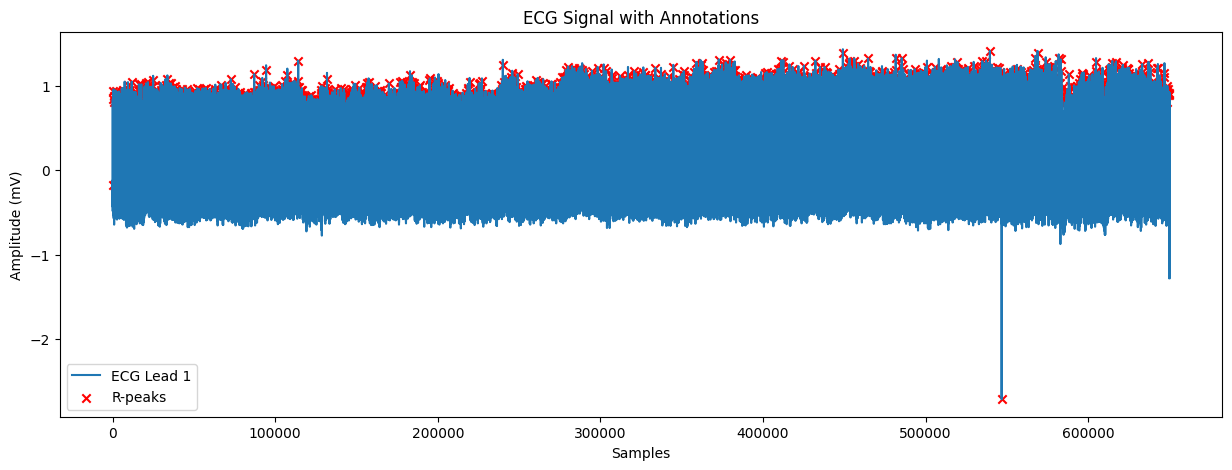

In [2]:

# Correct data path
data_path = r"C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/mitdb/mit-bih-arrhythmia-database-1.0.0"

# Read the signal and annotations
record = wfdb.rdrecord(os.path.join(data_path, '100'))
annotation = wfdb.rdann(os.path.join(data_path, '100'), 'atr')

# Plot a segment of the ECG with annotations
plt.figure(figsize=(15, 5))
plt.plot(record.p_signal[:, 0], label='ECG Lead 1')
plt.scatter(annotation.sample, [record.p_signal[i, 0] for i in annotation.sample],
            color='red', marker='x', label='R-peaks')
plt.title('ECG Signal with Annotations')
plt.xlabel('Samples')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.show()


 ## 1️⃣Feature extraction (HRV + arrhythmia)

In [3]:
# 
# ---------------------------------
data_path = r"C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/mitdb/mit-bih-arrhythmia-database-1.0.0"
records = [f.split('.')[0] for f in os.listdir(data_path) if f.endswith('.hea')]

def compute_time_domain(rr_intervals):
    mean_rr = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
    pnn50 = nn50 / len(rr_intervals) if len(rr_intervals) > 0 else 0
    return mean_rr, sdnn, rmssd, pnn50

def compute_frequency_domain(rr_intervals, fs_interp=4):
    times = np.cumsum(rr_intervals)
    if len(times) < 4:
        return 0, 0, 0
    t_interp = np.arange(0, times[-1], 1/fs_interp)
    rr_interp = np.interp(t_interp, times, rr_intervals)
    freqs, psd = welch(rr_interp, fs=fs_interp)
    lf_power = np.trapezoid(psd[(freqs >= 0.04) & (freqs < 0.15)], freqs[(freqs >= 0.04) & (freqs < 0.15)])
    hf_power = np.trapezoid(psd[(freqs >= 0.15) & (freqs < 0.4)], freqs[(freqs >= 0.15) & (freqs < 0.4)])
    lf_hf_ratio = lf_power / hf_power if hf_power > 0 else 0
    return lf_power, hf_power, lf_hf_ratio

def calculate_arrhythmia_burden(annotation):
    total_beats = len(annotation.symbol)
    abnormal_beats = sum([1 for s in annotation.symbol if s in ['V', 'A', 'F', 'L', 'R', 'E']])
    return abnormal_beats / total_beats if total_beats > 0 else 0

features = []
for rec in records:
    try:
        record = wfdb.rdrecord(os.path.join(data_path, rec))
        annotation = wfdb.rdann(os.path.join(data_path, rec), 'atr')
        fs = record.fs
        r_peaks = annotation.sample / fs
        rr_intervals = np.diff(r_peaks)
        if len(rr_intervals) < 10:
            continue
        mean_rr, sdnn, rmssd, pnn50 = compute_time_domain(rr_intervals)
        lf_power, hf_power, lf_hf_ratio = compute_frequency_domain(rr_intervals)
        arrhythmia_burden = calculate_arrhythmia_burden(annotation)
        features.append({
            'record': rec, 'mean_rr': mean_rr, 'sdnn': sdnn, 'rmssd': rmssd, 'pnn50': pnn50,
            'lf_power': lf_power, 'hf_power': hf_power, 'lf_hf_ratio': lf_hf_ratio,
            'arrhythmia_burden': arrhythmia_burden
        })
    except Exception as e:
        print(f"Error processing {rec}: {e}")

df = pd.DataFrame(features)

In [16]:
# | Column                 | Meaning                                                 |
# | ---------------------- | ------------------------------------------------------- |
# | **record**             | The MIT-BIH ECG record ID (e.g., “100”)                 |
# | **mean\_rr**           | Average time between heartbeats (seconds)               |
# | **sdnn**               | Variability of heartbeats overall (seconds)             |
# | **rmssd**              | Short-term variability of heartbeats (seconds)          |
# | **pnn50**              | % of heartbeat intervals differing by >50 ms            |
# | **lf\_power**          | Low frequency HRV power (sympathetic + parasympathetic) |
# | **hf\_power**          | High frequency HRV power (mostly parasympathetic)       |
# | **lf\_hf\_ratio**      | Balance between sympathetic & parasympathetic           |
# | **arrhythmia\_burden** | % of abnormal beats in the recording                    |
# | **risk\_label**        | Binary risk classification based on thresholds          |
# | **can_flags**        | Binary risk classification based on thresholds          |
# | **possible_can_risk**        | Binary risk classification based on thresholds          |

df

,record,mean_rr,sdnn,rmssd,pnn50,lf_power,hf_power,lf_hf_ratio,arrhythmia_burden,can_flags,possible_can_risk
0,100,0.794316,0.050584,0.064672,0.103388,0.000068,0.000625,0.109576,0.014952,2,1
1,101,0.963612,0.085589,0.071515,0.216765,0.000540,0.000844,0.639426,0.001601,0,0
2,102,0.823804,0.043082,0.048406,0.115016,0.000103,0.000600,0.171592,0.001825,3,1
3,103,0.863708,0.059102,0.047190,0.112919,0.000297,0.000622,0.476929,0.000956,3,1
4,104,0.781433,0.116285,0.124607,0.322511,0.001111,0.002990,0.371641,0.000865,1,0
5,105,0.670873,0.123802,0.153803,0.167658,0.000973,0.002337,0.416338,0.015236,1,0
6,106,0.860632,0.276383,0.432527,0.657129,0.002532,0.010728,0.235986,0.247855,1,0
7,107,0.843724,0.047745,0.054903,0.101449,0.000191,0.000632,0.301777,0.027570,2,1
8,108,0.990044,0.182268,0.201915,0.466264,0.004380,0.005882,0.744637,0.012610,0,0
9,109,0.712436,0.041671,0.047684,0.080900,0.000039,0.000444,0.088364,0.998817,3,1


## 2️⃣ CAN screening flags


In [5]:
# ---------------------------------
# ---------------------------------
def can_risk_flags(row):
    flags = 0
    if row['sdnn'] < 0.08:    # relaxed from 0.03
        flags += 1
    if row['rmssd'] < 0.05:   # relaxed from 0.02
        flags += 1
    if row['lf_hf_ratio'] < 0.5:
        flags += 1
    return flags

df['can_flags'] = df.apply(can_risk_flags, axis=1)
df['possible_can_risk'] = (df['can_flags'] >= 2).astype(int)

print(df[['sdnn', 'rmssd', 'lf_hf_ratio', 'can_flags', 'possible_can_risk']].describe())
print(f"\n🚩 Possible CAN risk: {df['possible_can_risk'].sum()}/{len(df)} ({100*df['possible_can_risk'].mean():.1f}%)")


            sdnn      rmssd  lf_hf_ratio  can_flags  possible_can_risk
count  48.000000  48.000000    48.000000  48.000000          48.000000
mean    0.144507   0.178277     0.664733   1.041667           0.270833
std     0.106933   0.151748     0.663421   0.921570           0.449093
min     0.041671   0.025868     0.088364   0.000000           0.000000
25%     0.065804   0.068193     0.294843   0.000000           0.000000
50%     0.119079   0.132986     0.446175   1.000000           0.000000
75%     0.185934   0.226390     0.730342   2.000000           1.000000
max     0.629530   0.842900     3.156549   3.000000           1.000000

🚩 Possible CAN risk: 13/48 (27.1%)


## Features and target

In [6]:
X = df.drop(columns=['record', 'possible_can_risk'])
y = df['possible_can_risk']

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# clf = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0, eval_metric='logloss')
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# y_proba = clf.predict_proba(X_test)[:, 1]


## CRoss Validation to check best performing model

In [7]:




# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True),
    'XGBoost': XGBClassifier( eval_metric='logloss')  # Optional
}

# Cross-validation results
cv_results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[model_name] = scores
    print(f"{model_name} - Mean Accuracy: {np.mean(scores):.4f} | Std: {np.std(scores):.4f}")


Logistic Regression - Mean Accuracy: 1.0000 | Std: 0.0000
Random Forest - Mean Accuracy: 1.0000 | Std: 0.0000
SVM (RBF Kernel) - Mean Accuracy: 1.0000 | Std: 0.0000
XGBoost - Mean Accuracy: 0.9800 | Std: 0.0400


## Best parameterd prediction for XGBoost

In [8]:
# === XGBoost Grid Search ===
xgb = XGBClassifier( eval_metric='logloss')

xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0]
}

xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X, y)

print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best XGBoost Accuracy:", xgb_grid.best_score_)

Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best XGBoost Accuracy: 0.9800000000000001


### BUilding the XGBoost model

In [9]:

# Best hyperparameters from GridSearch
xgb_final = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    subsample=1.0,
    eval_metric='logloss'
)

# Train on full dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


xgb_final.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [13]:
y_pred = xgb_final.predict(X_test)
y_proba = xgb_final.predict_proba(X_test)[:, 1]

In [10]:
X_test.shape

(10, 9)

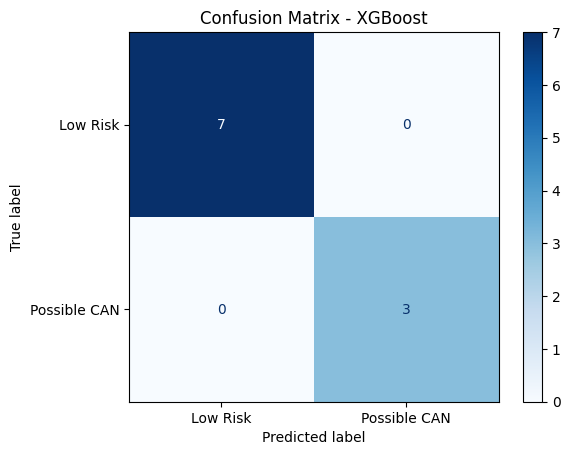

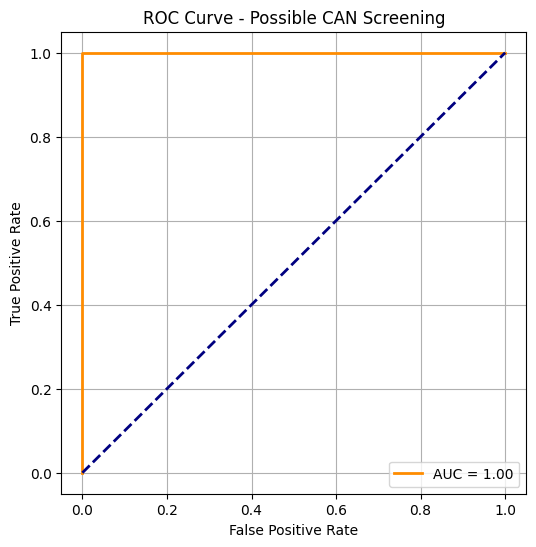

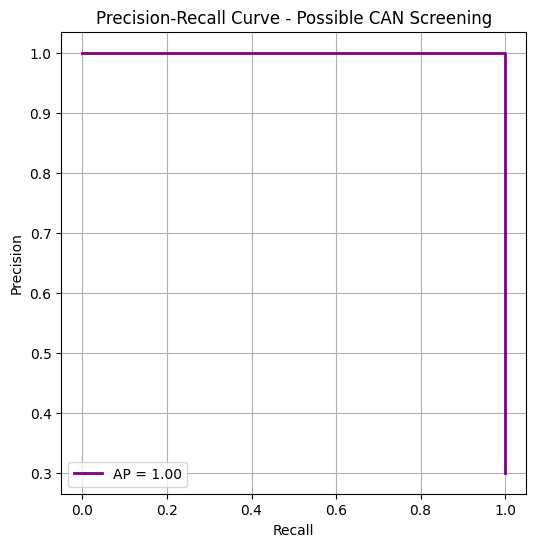

<Figure size 800x600 with 0 Axes>

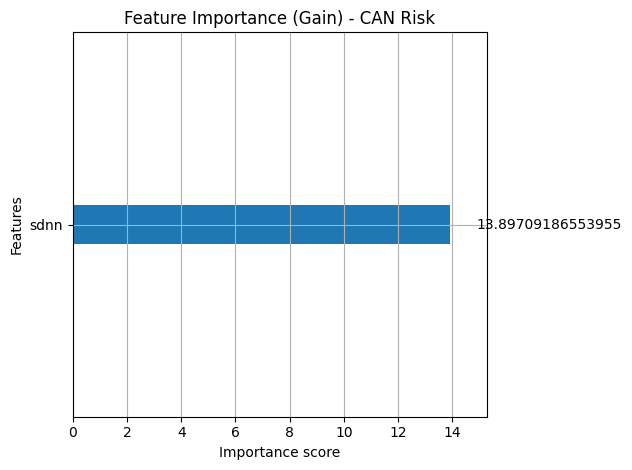

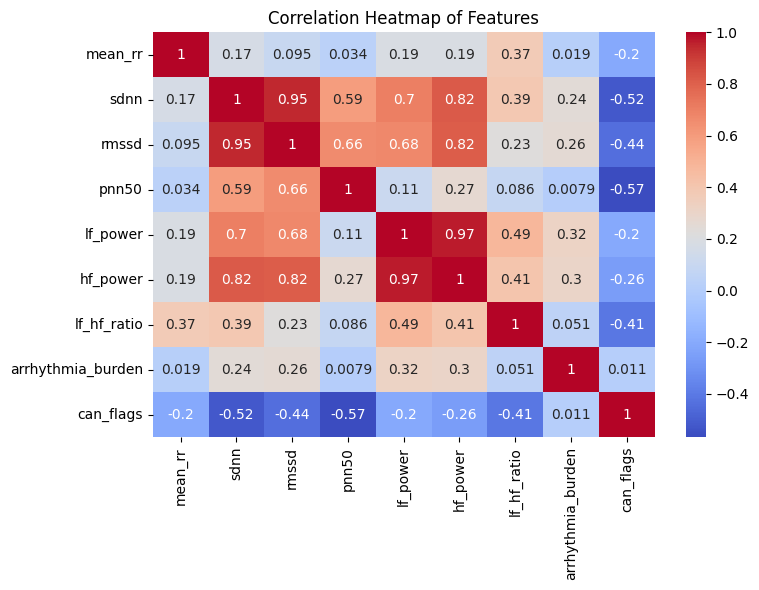

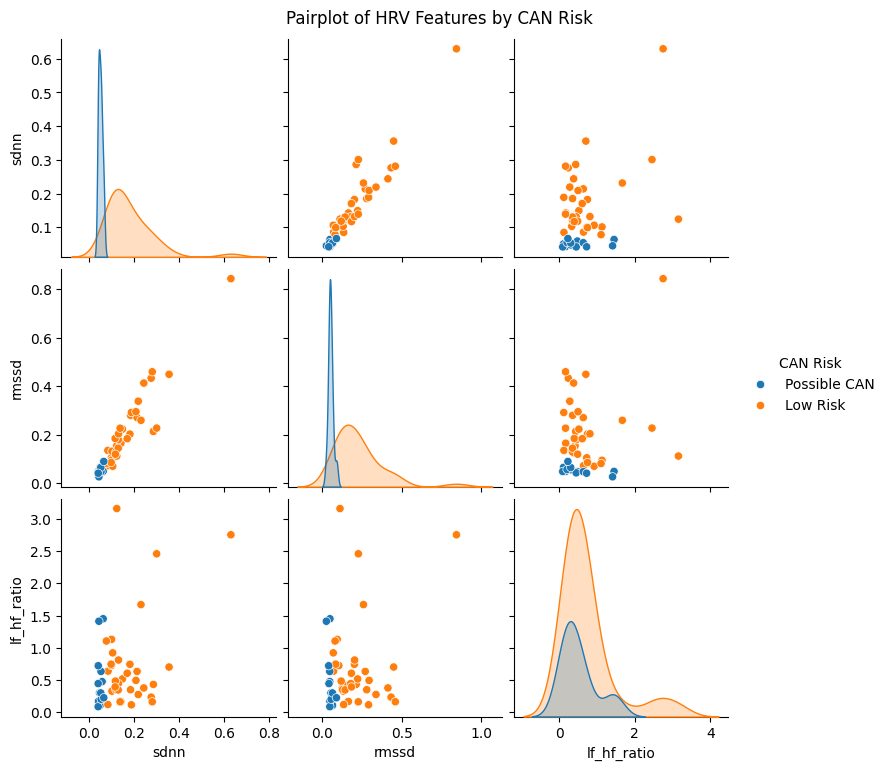


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [19]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Low Risk", "Possible CAN"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Possible CAN Screening")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {ap:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Possible CAN Screening")
plt.legend()
plt.grid()
plt.show()

# Feature importance
plt.figure(figsize=(8,6))
plot_importance(xgb_final, importance_type='gain', max_num_features=10)
plt.title("Feature Importance (Gain) - CAN Risk")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()

# Pairplot
df_plot = df.copy()
df_plot['CAN Risk'] = df_plot['possible_can_risk'].map({0: 'Low Risk', 1: 'Possible CAN'})
sns.pairplot(df_plot[['sdnn','rmssd','lf_hf_ratio','CAN Risk']], hue='CAN Risk', diag_kind='kde')
plt.suptitle("Pairplot of HRV Features by CAN Risk", y=1.02)
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


🚩 Possible CAN risk flags: 13/48 (27.1%)


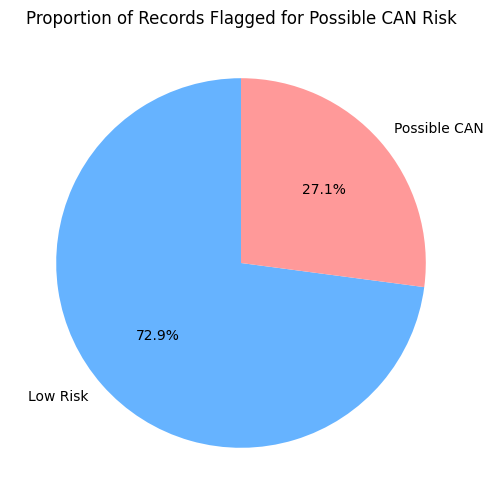

C:\Users\r\AppData\Local\Temp\ipykernel_21908\649124044.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='possible_can_risk', y='sdnn', data=df, palette='Set2')


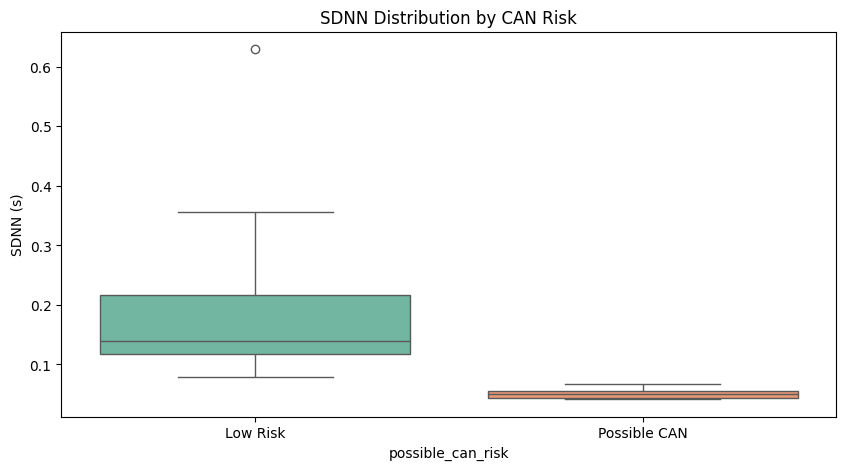

C:\Users\r\AppData\Local\Temp\ipykernel_21908\649124044.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='possible_can_risk', y='rmssd', data=df, palette='Set2')


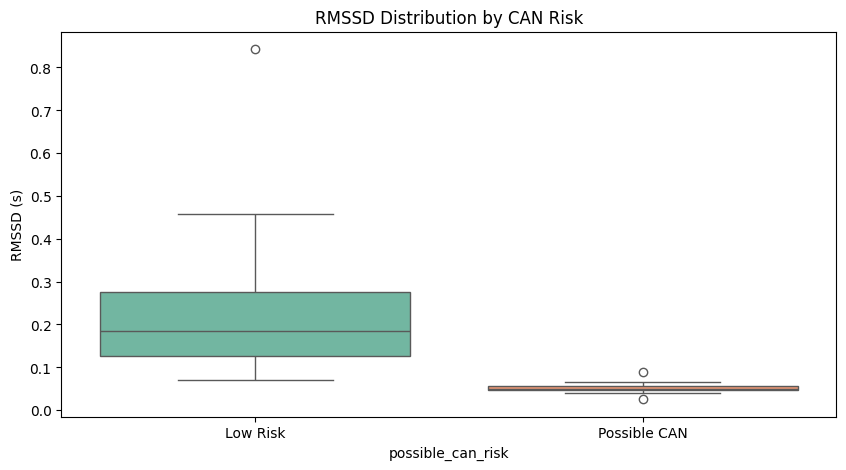

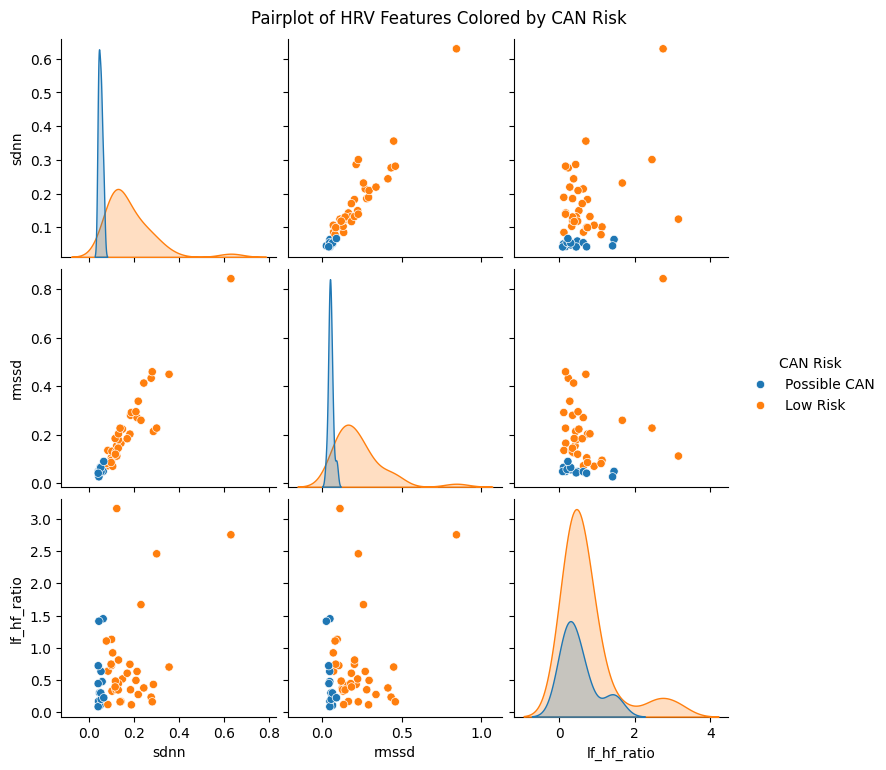

In [18]:

# Count of flagged cases
flag_count = df['possible_can_risk'].sum()
total_count = len(df)
print(f"\n🚩 Possible CAN risk flags: {flag_count}/{total_count} ({100*flag_count/total_count:.1f}%)")

# -------------------------------
# 📈 Pie Chart
# -------------------------------

# Ensure both categories exist for plotting
pie_counts = df['possible_can_risk'].value_counts().reindex([0,1], fill_value=0)

plt.figure(figsize=(6,6))
plt.pie(pie_counts, 
        labels=['Low Risk', 'Possible CAN'], 
        autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Proportion of Records Flagged for Possible CAN Risk')
plt.show()

# -------------------------------
# 📈 Boxplots to show separation
# -------------------------------
plt.figure(figsize=(10,5))
sns.boxplot(x='possible_can_risk', y='sdnn', data=df, palette='Set2')
plt.xticks([0,1], ['Low Risk', 'Possible CAN'])
plt.title('SDNN Distribution by CAN Risk')
plt.ylabel('SDNN (s)')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='possible_can_risk', y='rmssd', data=df, palette='Set2')
plt.xticks([0,1], ['Low Risk', 'Possible CAN'])
plt.title('RMSSD Distribution by CAN Risk')
plt.ylabel('RMSSD (s)')
plt.show()

# Optional pairplot
df_plot = df.copy()
df_plot['CAN Risk'] = df_plot['possible_can_risk'].map({0: 'Low Risk', 1: 'Possible CAN'})
sns.pairplot(df_plot[['sdnn','rmssd','lf_hf_ratio','CAN Risk']], hue='CAN Risk', diag_kind='kde')
plt.suptitle("Pairplot of HRV Features Colored by CAN Risk", y=1.02)
plt.show()